In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import os

import plotly.express as px
import plotly.graph_objects as go
from plotly.io import renderers
renderers.default = 'notebook'

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [157]:
def simulate_data_from_polynomial_w_noise(poly_degree=3, sample_size=300, min_x = 0.0, max_x=100.0,
                                        y_range_max=100.0, noise_mean=0.0, noise_var=10.0)-> (pd.DataFrame, dict):
    """ 
    Creates a polynomial of degree `poly_degree` that has roots between min_x and max_x
    and a range limited to [-y_range_max, y_range_max]. Then samples data points between
    min_x and max_x and returns a dataframe of that data with noise added of mean `noise_mean`
    and variance `noise_var`
    """


    # Generate random roots between min_x and max_x
    random_roots = np.random.uniform(min_x, max_x, size=poly_degree)
    sorted_roots = np.sort(random_roots)  # Sort roots for spacing
    roots = [sorted_roots[0]]  # Start with the first root

    # Create min root spacing
    min_spacing = (max_x - min_x)/(poly_degree*4)
    
    # Adjust roots to ensure minimum spacing
    for root in sorted_roots[1:]:
        spaced_root = max(roots[-1] + min_spacing, root)
        roots.append(spaced_root)
        
    # Define a polynomial function based on these roots
    def polynomial(x):
        poly = 1
        for root in roots:
            poly *= (x - root)
        return poly
    
    # Generate x values between min_x and max_x
    x_values = np.linspace(min_x, max_x, 400)
    
    # Compute the corresponding y values
    y_values = polynomial(x_values)
    
    # Scale the polynomial by adjusting the coefficient to ensure y values stay between -y_range_max and y_range_max
    y_max = np.max(y_values)
    y_min = np.min(y_values)
    
    # Find the scale factor that limits y range to within [-y_range_max, y_range_max]
    scale_factor = y_range_max / max(abs(y_max), abs(y_min))
    
    # Adjust the polynomial function by applying the scale factor
    def scaled_polynomial(x):
        return scale_factor * polynomial(x)
    
    # Sample data points between min_x and max_x
    X_sampled = np.random.uniform(min_x, max_x, sample_size)

    # Calculate the true y value based off the scaled polynomial
    y_true = scaled_polynomial(X_sampled)
    
    # Generate noise based on the given mean and variance
    noise = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=sample_size)
    
    # Add noise to the true y values to get observed y
    y_observed = y_true + noise

    # Create a pandas DataFrame
    sim_data_df = pd.DataFrame({'X': X_sampled,'y': y_observed})

    # Create string representation of polynomial
    terms = []
    for root in roots:
        if root == 0:
            terms.append(f"x")
        else:
            terms.append(f"(x - {root:.2f})")
    polynomial_str = f"f(x) = {scale_factor:.2f}" + "".join(terms)
    
    polynomial_dict = {
        'poly_string' : polynomial_str,
        'poly_degree' : poly_degree,
        'min_x' : min_x,
        'max_x' : max_x,
        'y_range_max': y_range_max,
        'roots' : roots,
        'poly_function': scaled_polynomial
    }

    return sim_data_df, polynomial_dict



In [158]:
def polynomial_regression_with_metrics_basic(df, x_vars, y_var, estimator_degree=1, test_size=0.2, random_state=42 ):
    """
    Perform polynomial expansion of the X variables, split the data into train, test, and out-of-distribution sets, 
    fit a linear model, and return metrics.
    
    Args:
        df (pd.DataFrame): Input DataFrame with X and y variables.
        x_vars (list): List of column names for X variables.
        y_var (str): Name of the target variable (y).
        estimator_degree (int): Degree of polynomial expansion (default=1).
        test_size (float): Proportion of the in-distribution data to include in the test split (default=0.2).
        random_state (int): Random seed for reproducibility (default=42).
        
    Returns:
        metrics (dict): A dictionary containing MSE for train, test, and out-of-distribution sets.
        estimator_info (dict): A dictionary containing model and additional info.
    """
    
    if type(x_vars) is str:
        x_vars = [x_vars]
        
    # Extract the features (X) and target (y)
    X = df[x_vars]
    y = df[y_var]
    

    # Create polynomial features (without interaction terms)
    poly = PolynomialFeatures(degree=estimator_degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    X_train = X_poly; y_train = y 
    X_test = X_poly; y_test = y 
    X_out = X_poly; y_out = y 
    train_idx = None
    test_idx = None
    out_of_distribution_idx = None
    
    # Fit a linear estimator (linear regression)
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on the train, test, and out-of-distribution sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_out_pred = model.predict(X_out)
    
    # Calculate the mean squared error for all sets
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mse_out_of_distribution = mean_squared_error(y_out, y_out_pred)
    
    # Prepare the results
    metrics = {
        'MSE_train': mse_train,
        'MSE_test': mse_test,
        'MSE_out_of_distribution': mse_out_of_distribution,
        'MSE_ratio_test_train': mse_test / mse_train if mse_train != 0 else np.inf,
        'MSE_ratio_out_train': mse_out_of_distribution / mse_train if mse_train != 0 else np.inf
    }
    
    estimator_info = {
        'model': model,
        'degree': estimator_degree,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'polynomial_features': poly.get_feature_names_out(x_vars),
        'train_idx': train_idx,
        'test_idx': test_idx,
        'out_of_distribution_idx': out_of_distribution_idx
    }
    
    return metrics, estimator_info

In [159]:
def polynomial_regression_with_metrics(df, x_vars, y_var, estimator_degree=1, test_size=0.2, random_state=42 ):
    """
    Perform polynomial expansion of the X variables, split the data into train, test, and out-of-distribution sets, 
    fit a linear model, and return metrics.
    
    Args:
        df (pd.DataFrame): Input DataFrame with X and y variables.
        x_vars (list): List of column names for X variables.
        y_var (str): Name of the target variable (y).
        estimator_degree (int): Degree of polynomial expansion (default=1).
        test_size (float): Proportion of the in-distribution data to include in the test split (default=0.2).
        random_state (int): Random seed for reproducibility (default=42).
        
    Returns:
        metrics (dict): A dictionary containing MSE for train, test, and out-of-distribution sets.
        estimator_info (dict): A dictionary containing model and additional info.
    """
    
    if type(x_vars) is str:
        x_vars = [x_vars]
        
    # Extract the features (X) and target (y)
    X = df[x_vars]
    y = df[y_var]
    

    # Create polynomial features (without interaction terms)
    poly = PolynomialFeatures(degree=estimator_degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Use the first variable in x_vars for percentile splitting
    x_first = X[x_vars[0]].values
    percentile_80 = np.percentile(x_first, 80)
    
    # Split data into in-distribution and out-of-distribution based on the 80th percentile
    in_distribution_mask = x_first <= percentile_80
    out_of_distribution_mask = x_first > percentile_80
    
    # Get indices
    in_distribution_indices = np.where(in_distribution_mask)[0]
    out_of_distribution_indices = np.where(out_of_distribution_mask)[0]
    
    # Get in-distribution data
    X_in = X_poly[in_distribution_mask]
    y_in = y.values[in_distribution_mask]
    
    # Split in-distribution data into train and test randomly
    indices_in = in_distribution_indices
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
        X_in, y_in, indices_in, test_size=test_size, random_state=random_state)
    
    # Out-of-distribution data
    X_out = X_poly[out_of_distribution_mask]
    y_out = y.values[out_of_distribution_mask]
    out_of_distribution_idx = out_of_distribution_indices
    
    # Fit a linear estimator (linear regression)
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on the train, test, and out-of-distribution sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_out_pred = model.predict(X_out)
    
    # Calculate the mean squared error for all sets
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mse_out_of_distribution = mean_squared_error(y_out, y_out_pred)
    
    # Prepare the results
    metrics = {
        'MSE_train': mse_train,
        'MSE_test': mse_test,
        'MSE_out_of_distribution': mse_out_of_distribution,
        'MSE_ratio_test_train': mse_test / mse_train if mse_train != 0 else np.inf,
        'MSE_ratio_out_train': mse_out_of_distribution / mse_train if mse_train != 0 else np.inf
    }
    
    estimator_info = {
        'model': model,
        'degree': estimator_degree,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'polynomial_features': poly.get_feature_names_out(x_vars),
        'train_idx': train_idx,
        'test_idx': test_idx,
        'out_of_distribution_idx': out_of_distribution_idx
    }
    
    return metrics, estimator_info

In [160]:
def plot_overfitting(df, polynomial_dict, estimator_info=None):

    if estimator_info is not None:
        n_plots = 2
    else:
        n_plots = 1

    # Create subplots: one for simulated data, another for simulated data + estimator
    fig, axes = plt.subplots(1, 1, figsize=(12, 6)) 

    # Generate points using the polynomial function and add to the plot
    x_range = np.linspace(polynomial_dict['min_x'], polynomial_dict['max_x'], 500)
    polynomial_y_values = polynomial_dict['poly_function'](x_range)


    model = estimator_info['model']
    lin_estimator_degree = estimator_info['degree']  # Extract the degree from estimator_info
    
    # Expand the data using the degree from estimator_info
    poly = PolynomialFeatures(degree=lin_estimator_degree, include_bias=False)
    x_range_poly = poly.fit_transform(x_range.reshape(-1,1))
    
    # Predict y values using the trained model
    y_range_pred = model.predict(x_range_poly)
    



    #axes.set_title(f"Fitted Linear Estimator (Degree = {lin_estimator_degree})")
    #axes[a].set_title(f"Simulated Data Split Up")
    train_idx, test_idx, OOD_idx = (estimator_info['train_idx'], estimator_info['test_idx'], estimator_info['out_of_distribution_idx'])
    axes.plot(df['X'], df['y'], marker='o', linestyle='', color='b', alpha=.2, label='Data')
    axes.plot(x_range, y_range_pred, color='red', linestyle='-', label=f'Fitted Linear Estimator (Degree {lin_estimator_degree})')

    axes.axhline(y=0, color='black', linestyle='-', linewidth=1)
    #axes.plot(x_range, polynomial_y_values, linestyle='--', color='lightblue', label='True Polynomial')

    axes.grid(True)
    axes.set_ylim(-1 * polynomial_dict['y_range_max'], polynomial_dict['y_range_max'])
    #axes.set_xlabel('X values')
    #axes.set_ylabel('Y values')
    #axes.legend(loc='upper left')

    plt.tight_layout()

    return fig, axes


In [227]:
def make_plot_minimalistic(fig, grid_lines=False, base_size=4):
    """
    Applies minimalistic styling to a matplotlib figure while keeping gridlines and adding axis arrows.

    Parameters:
        fig (matplotlib.figure.Figure): The matplotlib figure to style.
        grid_lines (bool): Whether to enable gridlines.
        base_size (int): The base dimension for a single subplot (width and height).
    """
    axes = fig.get_axes()
    n_axes = len(axes)

    for ax in axes:
        if grid_lines:
            # Enable gridlines for x and y
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)
            ax.annotate('', xy=(1, 0), xycoords='axes fraction', xytext=(1.05, 0), 
                        arrowprops=dict(facecolor='black', arrowstyle='->', lw=1))
            ax.annotate('', xy=(0, 1), xycoords='axes fraction', xytext=(0, 1.05), 
                        arrowprops=dict(facecolor='black', arrowstyle='->', lw=1))
            # Customize ticks
            ax.tick_params(left=True, bottom=True, labelleft=False, labelbottom=False, direction='out', length=4)
        else:
            # Disable all spines and gridlines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.grid(False)  # Explicitly disable gridlines
            # Add central axis lines
            ax.axhline(0, color='black', linewidth=2, linestyle='-', alpha=0.7)
            ax.axvline(0, color='black', linewidth=2, linestyle='-', alpha=0.7)
            # Remove ticks
            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, direction='out', length=4)

        # Highlight data
        for line in ax.get_lines():
            pass
            #line.set_linewidth(2)  # Thicken lines
            #line.set_alpha(0.8)   # Increase visibility of lines

        # Highlight scatter points (if any)
        for collection in ax.collections:
            if hasattr(collection, 'set_sizes'):
                collection.set_sizes([30])  # Standardize point size
            #collection.set_alpha(0.8)     # Increase visibility of points

    # Adjust figure size based on number of subplots
    rows, cols = fig.axes[-1].get_subplotspec().get_gridspec().get_geometry()
    fig_width = cols * base_size
    fig_height = rows * base_size
    fig.set_size_inches(fig_width, fig_height)
    fig.tight_layout()


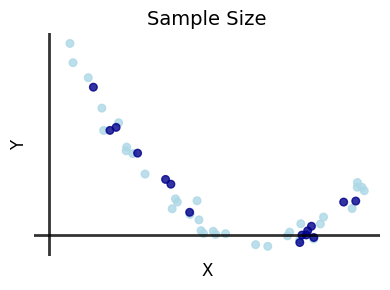

In [163]:
df, poly_dict =  simulate_data_from_polynomial_w_noise(2, 50, )
df['group'] = 0
df.loc[35:, 'group'] = 1

fig, ax = plt.subplots()
colors = df['group'].map({0: 'lightblue', 1: 'darkblue'})  # Map groups to specific colors
ax.scatter(df['X'], df['y'], c=colors)

ax.set_title("Sample Size", fontsize=14)
ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)

# Apply minimalistic formatting
make_plot_minimalistic(fig)

# Display the plot
plt.show()

fig.savefig(os.path.join( 'data-science-demo', 'output', 'writeup', "scatter_plot.png"), transparent=True, dpi=300)

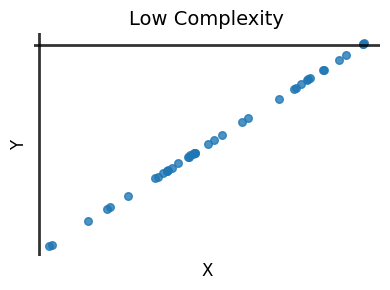

In [164]:
df, poly_dict =  simulate_data_from_polynomial_w_noise(1, 40, noise_var=.00001 )

fig, ax = plt.subplots()
ax.scatter(df['X'], df['y'])
ax.set_title("Low Complexity", fontsize=14)
ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)

# Apply minimalistic formatting
make_plot_minimalistic(fig)

# Display the plot
plt.show()

fig.savefig(os.path.join( 'data-science-demo', 'output', 'writeup', "low_model_complexity.png"), transparent=True, dpi=300)

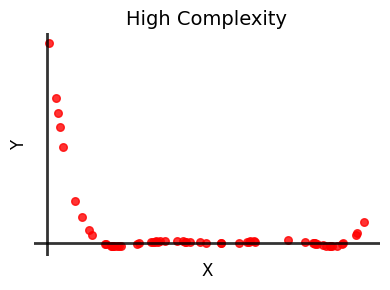

In [165]:
df, poly_dict =  simulate_data_from_polynomial_w_noise(6, 60, noise_var=.01 )

fig, ax = plt.subplots()
ax.scatter(df['X'], df['y'], color='red')
ax.set_title("High Complexity", fontsize=14)
ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)

# Apply minimalistic formatting
make_plot_minimalistic(fig)

# Display the plot
plt.show()

fig.savefig(os.path.join( 'data-science-demo', 'output', 'writeup', "high_model_complexity.png"), transparent=True, dpi=300)

In [166]:
sim_data_df, polynomial_dict = simulate_data_from_polynomial_w_noise(poly_degree=2, noise_var = 200 , sample_size=18)

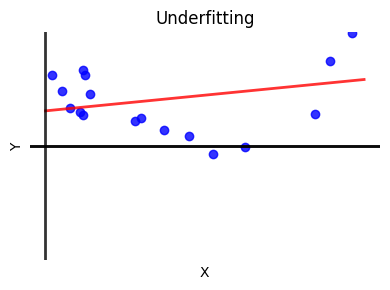

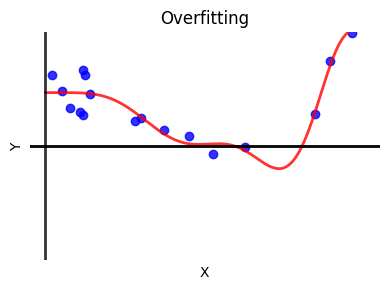

In [167]:
iterations = [ {'degree':1, 'label':'Underfitting'},
              {'degree':11, 'label':'Overfitting'} ]

for iteration in iterations :
    degree, label = (iteration['degree'], iteration['label'])

    metrics, estimator_info = polynomial_regression_with_metrics_basic(sim_data_df, 'X', 'y', estimator_degree=degree)
    fig, axes = plot_overfitting(sim_data_df, polynomial_dict, estimator_info)
    axes.set_title(label)
    axes.set_xlabel('X')
    axes.set_ylabel('Y')
    make_plot_minimalistic(fig)
    figname = f'{label}_minimialistic.png'
    plt.show()
    
    fig.savefig(os.path.join( 'data-science-demo', 'output', 'writeup', f"{figname}.png"), transparent=True, dpi=300)


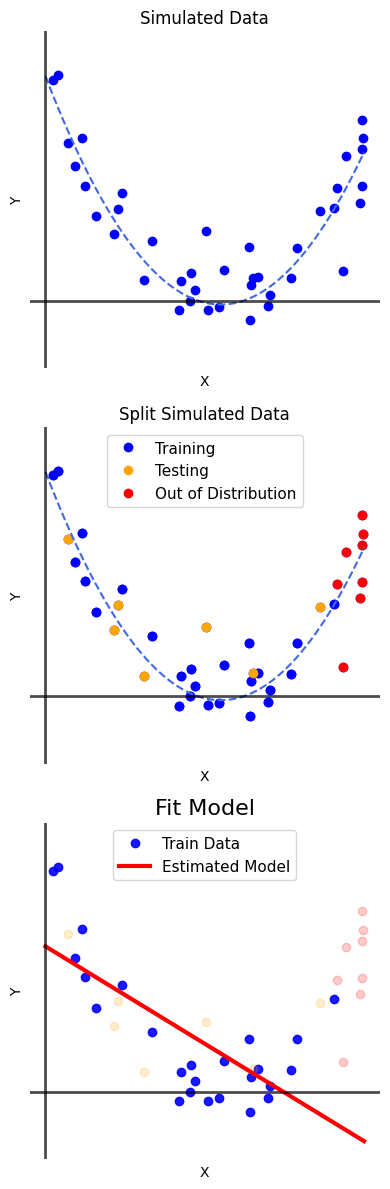

In [228]:
def plot_sim_data_splits_for_demo(df, polynomial_dict, estimator_info) -> fig:


    # Create subplots: one for simulated data, another for simulated data + estimator
    fig, axes = plt.subplots(3, 1, figsize=(12, 6)) 

    # Generate points using the polynomial function and add to the plot
    x_range = np.linspace(polynomial_dict['min_x'], polynomial_dict['max_x'], 500)
    polynomial_y_values = polynomial_dict['poly_function'](x_range)

    if estimator_info is not None:

        model = estimator_info['model']
        lin_estimator_degree = estimator_info['degree']  # Extract the degree from estimator_info
        
        # Expand the data using the degree from estimator_info
        poly = PolynomialFeatures(degree=lin_estimator_degree, include_bias=False)
        x_range_poly = poly.fit_transform(x_range.reshape(-1,1))
        
        # Predict y values using the trained model
        y_range_pred = model.predict(x_range_poly)
        
    # First subplot: Simulated data only
    axes[0].plot(df['X'], df['y'], marker='o', linestyle='', color='b', alpha=1)
    axes[0].set_title(f"Simulated Data")
    axes[0].plot(x_range, polynomial_y_values, linestyle='--', color='royalblue')


    train_idx, test_idx, OOD_idx = (estimator_info['train_idx'], estimator_info['test_idx'], estimator_info['out_of_distribution_idx'])
    axes[1].plot(df['X'], df['y'], marker='o', linestyle='', color='b', alpha=1)
    axes[1].plot(df.loc[train_idx]['X'], df.loc[train_idx]['y'], marker='o', linestyle='', color='b', alpha=1, label='Training')
    axes[1].plot(df.loc[test_idx]['X'], df.loc[test_idx]['y'], marker='o', linestyle='', color='orange', alpha=1, label='Testing')
    axes[1].plot(df.loc[OOD_idx]['X'], df.loc[OOD_idx]['y'], marker='o', linestyle='', color='red', alpha=1, label='Out of Distribution')
    axes[1].set_title(f"Split Simulated Data")
    axes[1].plot(x_range, polynomial_y_values, linestyle='--', color='royalblue')
    axes[1].legend(loc='upper center')



    axes[2].plot(df.loc[train_idx]['X'], df.loc[train_idx]['y'], marker='o', linestyle='', color='b', alpha=.9, label='Train Data')
    axes[2].plot(df.loc[test_idx]['X'], df.loc[test_idx]['y'], marker='o', linestyle='', color='orange', alpha=.2)
    axes[2].plot(df.loc[OOD_idx]['X'], df.loc[OOD_idx]['y'], marker='o', linestyle='', color='red', alpha=.2)
    axes[2].set_title(f"Fit Model", fontsize=16)
    axes[2].plot(x_range, y_range_pred, linestyle='-', color='red', label='Estimated Model', alpha=1, linewidth=3)
    axes[2].legend(loc='upper center')


    for a in [0,1,2]:
        axes[a].set_ylim(-1 * polynomial_dict['y_range_max'], polynomial_dict['y_range_max'])
        axes[a].set_xlabel('X')
        axes[a].set_ylabel('Y')
        axes[a].set_ylim( [-30, 120])
        if a!=0:
            axes[a].legend(fontsize=11,loc='upper center')


    return fig, axes

#sim_data_df, polynomial_dict = simulate_data_from_polynomial_w_noise(poly_degree=2, noise_var = 200 , sample_size=40)
metrics, estimator_info = polynomial_regression_with_metrics(sim_data_df, 'X', 'y', estimator_degree=1)
fig, axes = plot_sim_data_splits_for_demo(sim_data_df,polynomial_dict, estimator_info )
make_plot_minimalistic(fig)

fig.savefig(os.path.join( 'data-science-demo', 'output', 'writeup', "plugin_graphs.png"), transparent=False, dpi=300)

In [203]:
polynomial_dict

{'poly_string': 'f(x) = 0.03(x - 47.97)(x - 62.10)',
 'poly_degree': 2,
 'min_x': 0.0,
 'max_x': 100.0,
 'y_range_max': 100.0,
 'roots': [np.float64(47.96891514521331), np.float64(62.103961861670065)],
 'poly_function': <function __main__.simulate_data_from_polynomial_w_noise.<locals>.scaled_polynomial(x)>}

In [204]:
metrics

{'MSE_train': np.float64(463.16180031904906),
 'MSE_test': np.float64(547.8127293482986),
 'MSE_out_of_distribution': np.float64(6006.596584358347),
 'MSE_ratio_test_train': np.float64(1.182767510124837),
 'MSE_ratio_out_train': np.float64(12.968678721390024)}